In [1]:
# Let's start with necessary imports
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

2025-01-11 20:30:51.055294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-11 20:30:51.949616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load data and normalize it
background = np.load('background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load('bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load('sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

In [15]:
# Add labels to data
background_labels = np.zeros(len(background))  # Label 0 for background
bbh_labels = np.ones(len(bbh))  # Label 1 for BBH
sglf_labels = np.full(len(sglf), 2) # Label 2 for Sine-Gaussian

In [18]:
# Combine normal, black hole, and unknown into one dataset with labels
X = np.concatenate((background, bbh, sglf), axis=0)
y = np.concatenate((background_labels, bbh_labels, sglf_labels), axis=0)

In [19]:
# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (240000, 200, 2) (60000, 200, 2)
y train/test shapes: (240000,) (60000,)


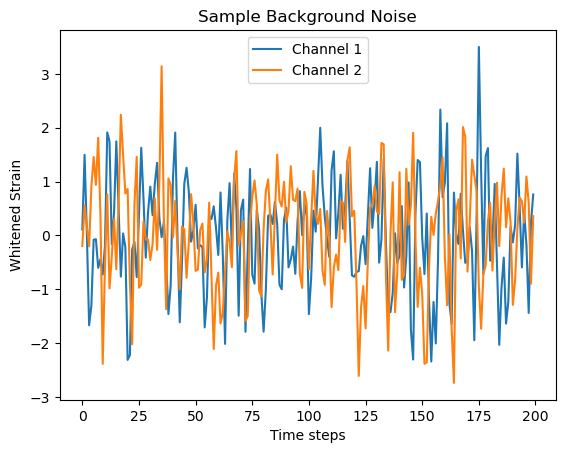

In [12]:
import matplotlib.pyplot as plt

# Plot the first sample
sample = x_train[0]
plt.plot(sample[:, 0], label="Channel 1")
plt.plot(sample[:, 1], label="Channel 2")
plt.xlabel("Time steps")
plt.ylabel("Whitened Strain")
plt.legend()
plt.title("Sample Background Noise")
plt.show()

In [5]:
class Model:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1

# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


2025-01-11 20:32:04.365594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20732 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:e1:00.0, compute capability: 8.6


Epoch 1/50


I0000 00:00:1736627530.395321    4508 service.cc:145] XLA service 0x7f8f10002c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736627530.395378    4508 service.cc:153]   StreamExecutor device (0): NVIDIA A10, Compute Capability 8.6
2025-01-11 20:32:10.559205: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-11 20:32:11.173234: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1736627541.783442    4537 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_64', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1736627542.061355    4536 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_70', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1736627543.06

  40/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.4373    

I0000 00:00:1736627556.137026    4508 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1988/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6002

I0000 00:00:1736627565.039553    4767 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_17', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1736627565.348777    4765 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_17', 240 bytes spill stores, 220 bytes spill loads

I0000 00:00:1736627565.870779    4766 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_17', 16 bytes spill stores, 24 bytes spill loads

I0000 00:00:1736627566.762325    4767 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_17', 1048 bytes spill stores, 1020 bytes spill loads



2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - loss: 1.5969 - val_loss: 0.6718
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6431 - val_loss: 0.5276
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5505 - val_loss: 0.5117
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5303 - val_loss: 0.4929
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4931 - val_loss: 0.3630
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3448 - val_loss: 0.3006
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2350 - val_loss: 0.2759
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1815 - val_loss: 0.0685
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1061 - val_loss: 0.0992
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0814 - val_loss: 0.0273
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0545 - val_loss: 0.0193
Epoch 12/50
2000/2000 ━━━━━━━━━━━━━━━━━━

In [6]:
__file__=''
!mkdir -p saved_model
autoencoder.save('')

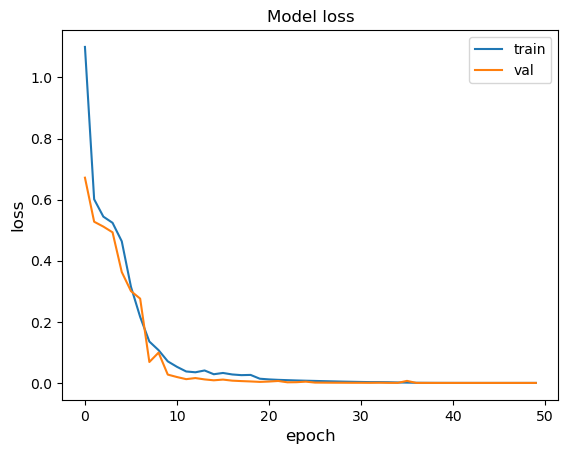

In [7]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 879us/step


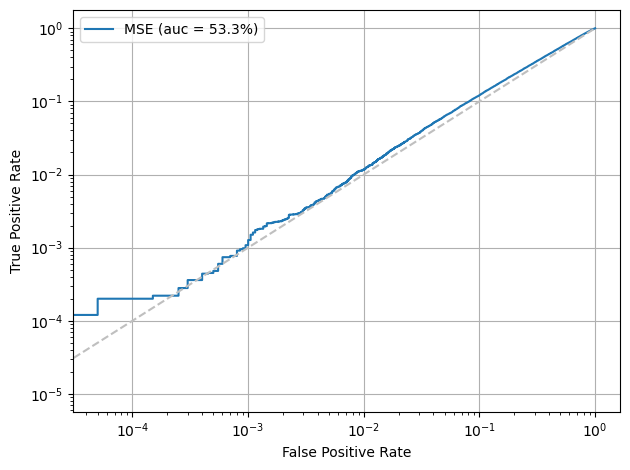

In [8]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh)

make_plot_roc_curves(background_test, signal_test)

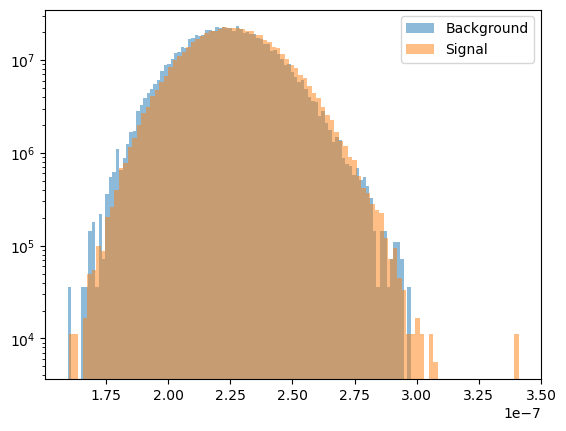

In [9]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [10]:
pretrained_model = Model()
pretrained_model.load()

# Check its architecture
pretrained_model.ae.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 2)    │      1,410 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 2)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 2)    │          4 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 200, 64)   │        192 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 200, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 200, 2)    │        130 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 2)    │          4 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 2)    │      1,410 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 200, 2)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 2)    │          4 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 200, 64)   │        192 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 200, 64)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 200, 2)    │        130 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 2)    │          4 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 206,060 (804.93 KB)

 Trainable params: 68,686 (268.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,374 (536.62 KB)